In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pymc as pm
from scipy.stats import gamma
from pymc.sampling_jax import get_jaxified_logp
import jax.numpy as jnp
import blackjax
import jax
import diffrax
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import arviz as az
import seaborn as sns
import preliz as pz
from diffrax_ODE_PyTensor import SolOp as SolOp_PyTensor
from diffrax_ODE_PyTensor import VJPSolOp as VJPSolOp_PyTensor
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

sys.path.append("../models/")
from huang_ferrell_1996 import *
from shin_2014 import *

from sampling_utils import *

plt.style.use('~/.matplotlib/custom.mplstyle')
# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
import plotting_helper_funcs as plt_func

jax.config.update("jax_enable_x64", True)

/Users/natetest/miniforge3/envs/pymc5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test the function to generate a dose reponse curve using the Shin 2014 model

In [3]:
S_2014 = shin_2014(transient=False)
y0_dict, y0 = S_2014.get_initial_conditions()
p_dict, plist = S_2014.get_nominal_params()

data = pd.read_csv("../../../results/MAPK/HF_96_synthetic_data.csv")
inputs = np.array(data['stimulus'].to_numpy())

y0_EGF_ins = construct_y0_EGF_inputs(inputs, np.array([y0]), 0)


[]

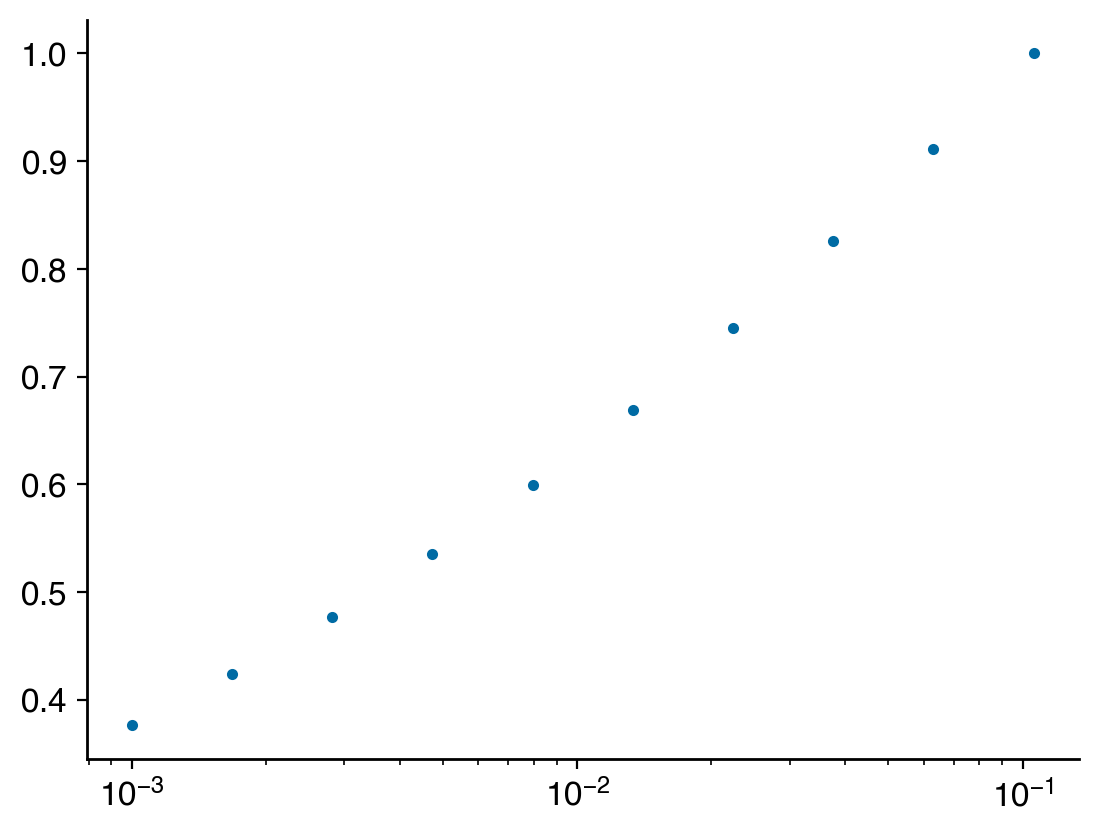

In [5]:
erk_act, _ = ERK_stim_response(plist, diffrax.ODETerm(S_2014), 540, y0_EGF_ins, [-1])
erk_act = np.array(erk_act)
fig, ax = plt.subplots()
ax.plot(inputs, erk_act, '.')
ax.semilogx()

### Test prior elicitation using preliz

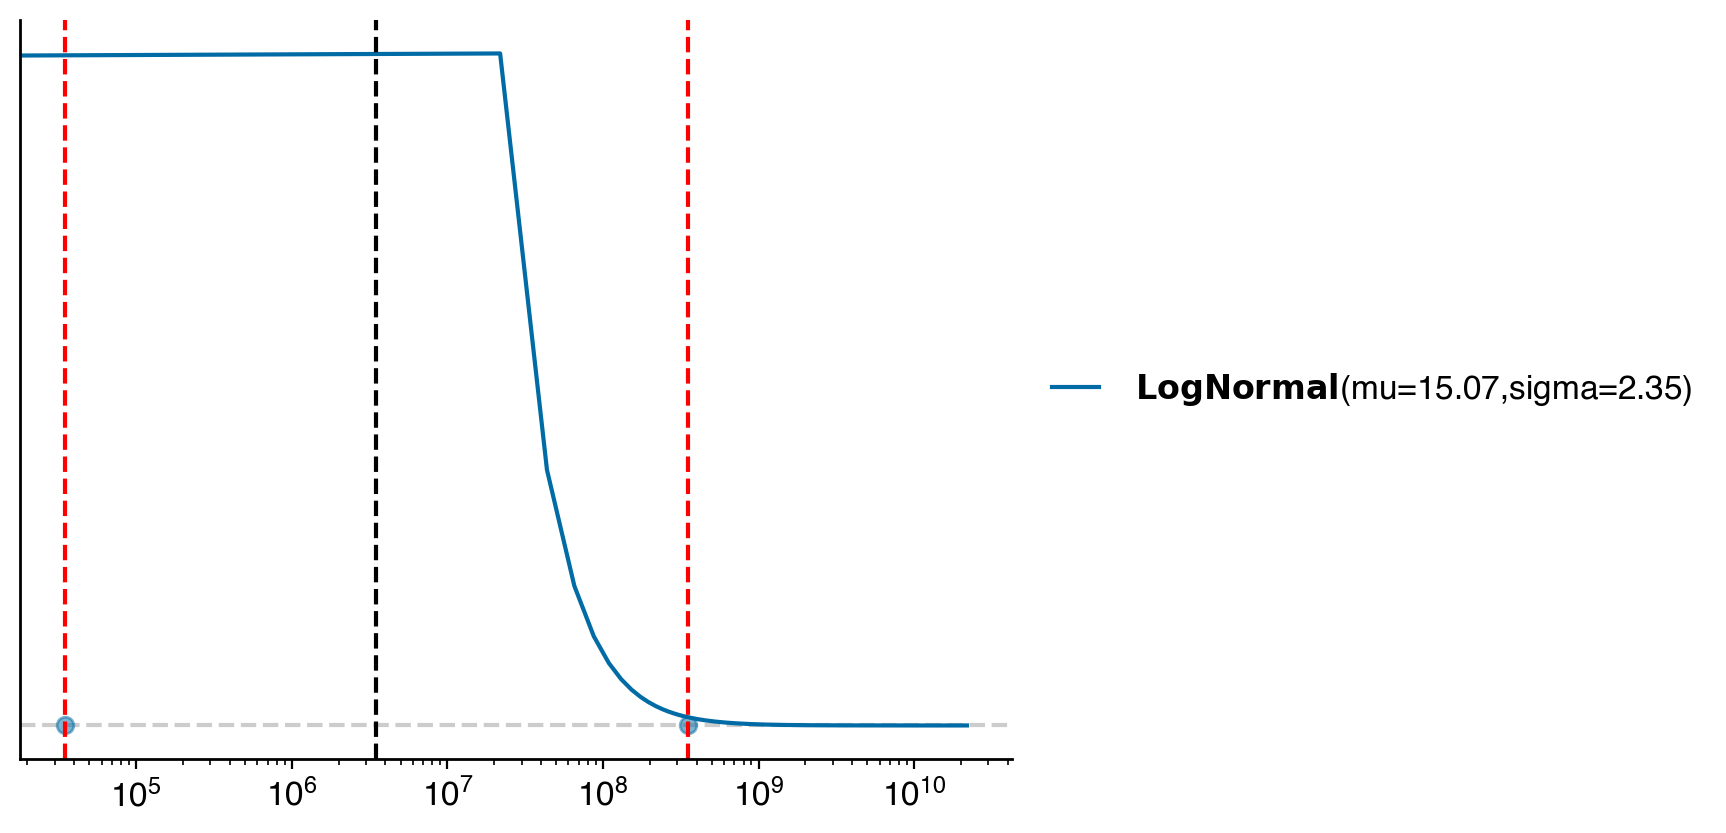

In [151]:
k = 3496490.0
upper, lower = 100*k, 0.01*k
results = pz.maxent(pz.LogNormal(mu=np.log(k)), lower, upper, 0.95, plot=True)
# print(results)
# ax = pz.LogNormal(mu=np.log(k), sigma=np.log(10)).plot_pdf(color='b')
ylim = results[0].get_ylim()
results[0].plot([k, k], ylim, 'k--')
results[0].plot([lower, lower], ylim, 'r--')
results[0].plot([upper, upper], ylim, 'r--')
results[0].set_ylim(ylim)
results[0].set_xscale('log')


In [131]:
pm.find_constrained_prior(pm.LogNormal, lower, upper, {'mu':1.0, 'sigma': 1.0}, mass=0.95, )

ValueError: Optimization of parameters failed.
Optimization termination details:
 message: Singular matrix C in LSQ subproblem
 success: False
  status: 6
     fun: 0.9506249999999999
       x: [ 1.000e+00  1.000e+00]
     nit: 1
     jac: [-2.815e-20 -2.663e-19]
    nfev: 1
    njev: 1

### Test the automatic model generation code

In [50]:
param_names = ['a','b','c']
nominal_values = [0.1,1e-7,0.1]
free_param_idxs = [1,2]
priors = set_prior_params(param_names, nominal_values, free_param_idxs, upper_mult=1.9, lower_mult=0.1, prior_family={'Gamma':['alpha','beta']}, prob_mass_bounds=0.95)
print(priors)

model = pm.Model()
with model:
    for key, value in priors.items():
        exec(key + ' = ' + value)
    
    plist = list(map(eval, priors.keys()))
    # print(plist)

print(model.value_vars)

init_vals = model.initial_point()
print(init_vals)

{'a': 'pm.ConstantData("a", 0.1)', 'b': 'pm.Gamma("b",alpha=4.498148159869361, beta=44567901.23456792, )', 'c': 'pm.Gamma("c",alpha=3.1989959668366437, beta=35.22781067467031, )'}
[b_log__, c_log__]
{'b_log__': array(-16.10885866), 'c_log__': array(-2.39899885)}


In [52]:
a = pm.Gamma("b",alpha=4.498148159869361, beta=44567901.23456792, )
# .eval(init_vals)

AttributeError: module 'pymc' has no attribute 'dist'

### Test building a pymc model with the Shin 2014 model

In [38]:
S_2014 = shin_2014(transient=False)
y0_dict, y0 = S_2014.get_initial_conditions()
p_dict, plist = S_2014.get_nominal_params()

data = pd.read_csv("../../../results/MAPK/HF_96_synthetic_data.csv")
inputs = np.array(data['stimulus'].to_numpy())
erk_act_data = data['response'].to_numpy()

y0_EGF_ins = construct_y0_EGF_inputs(0.001*inputs, np.array([y0]), 0)

# free params
free_param_names = ['kc47', 'kc43', 'kd39', 'kc45', 'ERK_tot', 'ki39', 'kc41']
free_param_idxs = [list(p_dict.keys()).index(name) for name in free_param_names]

# set priors
prior_param_dict = set_prior_params(list(p_dict.keys()), plist, free_param_idxs, prior_family={'Gamma':['alpha', 'beta']}, upper_mult=1.9, lower_mult=0.1, prob_mass_bounds=0.95)

In [39]:
test_dat = np.vstack((erk_act))
print(test_dat.shape)

erk_act_data = np.vstack((data['response'].to_numpy()))
print(erk_act_data.shape)

(10, 1)
(10, 1)


### Now try with the build_pymc_model function that I wrote

In [40]:
model1 = build_pymc_model(prior_param_dict, erk_act_data, y0_EGF_ins, 
                    [-1], 540, diffrax.ODETerm(S_2014))

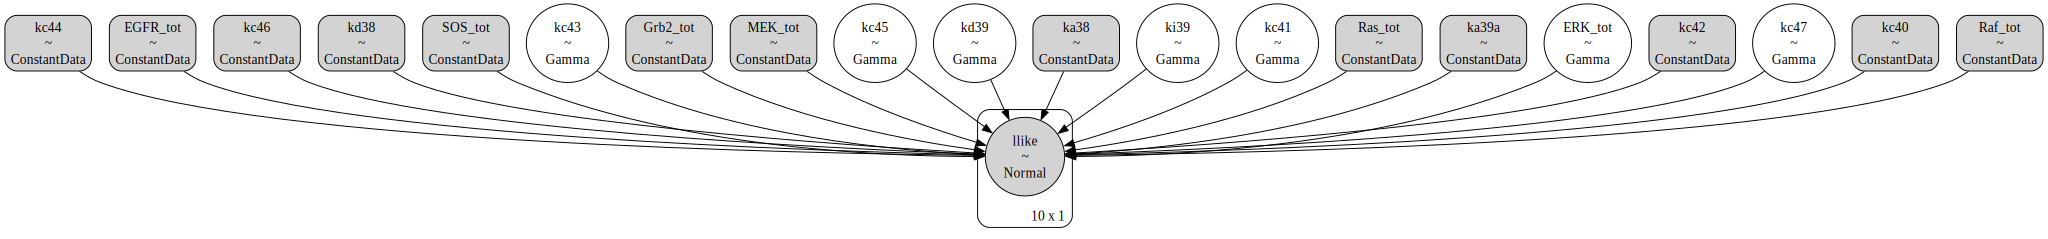

In [41]:
pm.model_to_graphviz(model1)

### How does prior predictive sampling look?

Sampling: [ERK_tot, kc41, kc43, kc45, kc47, kd39, ki39, llike]


(<Figure size 1280x960 with 1 Axes>,
 <Axes: xlabel='EGF stimulus', ylabel='% maximal ERK activity'>)

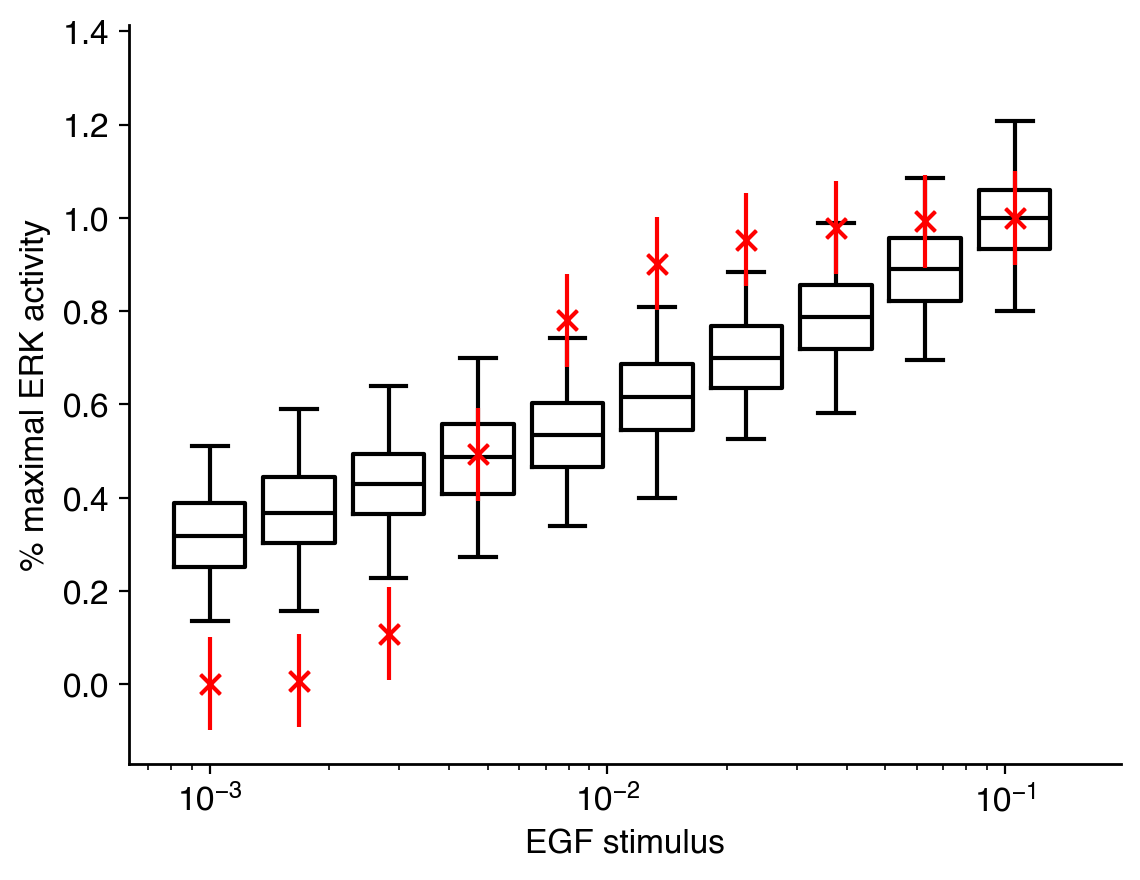

In [42]:
create_prior_predictive(model1, 'shin_2014', erk_act_data, inputs, './', 
                            nsamples=500, seed=np.random.default_rng(seed=123))

In [43]:
# sample
idata = smc_pymc(model1, 'shin_2014', './', nsamples=500, 
             seed=np.random.default_rng(seed=123))

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<xarray.Dataset>
Dimensions:  ()
Data variables:
    ERK_tot  float64 23.21
    ki39     float64 17.83
    kd39     float64 16.92
    kc41     float64 29.08
    kc43     float64 31.13
    kc45     float64 7.33
    kc47     float64 393.2
<xarray.Dataset>
Dimensions:  ()
Data variables:
    ERK_tot  float64 1.125
    ki39     float64 1.154
    kd39     float64 1.162
    kc41     float64 1.096
    kc43     float64 1.094
    kc45     float64 1.516
    kc47     float64 1.016


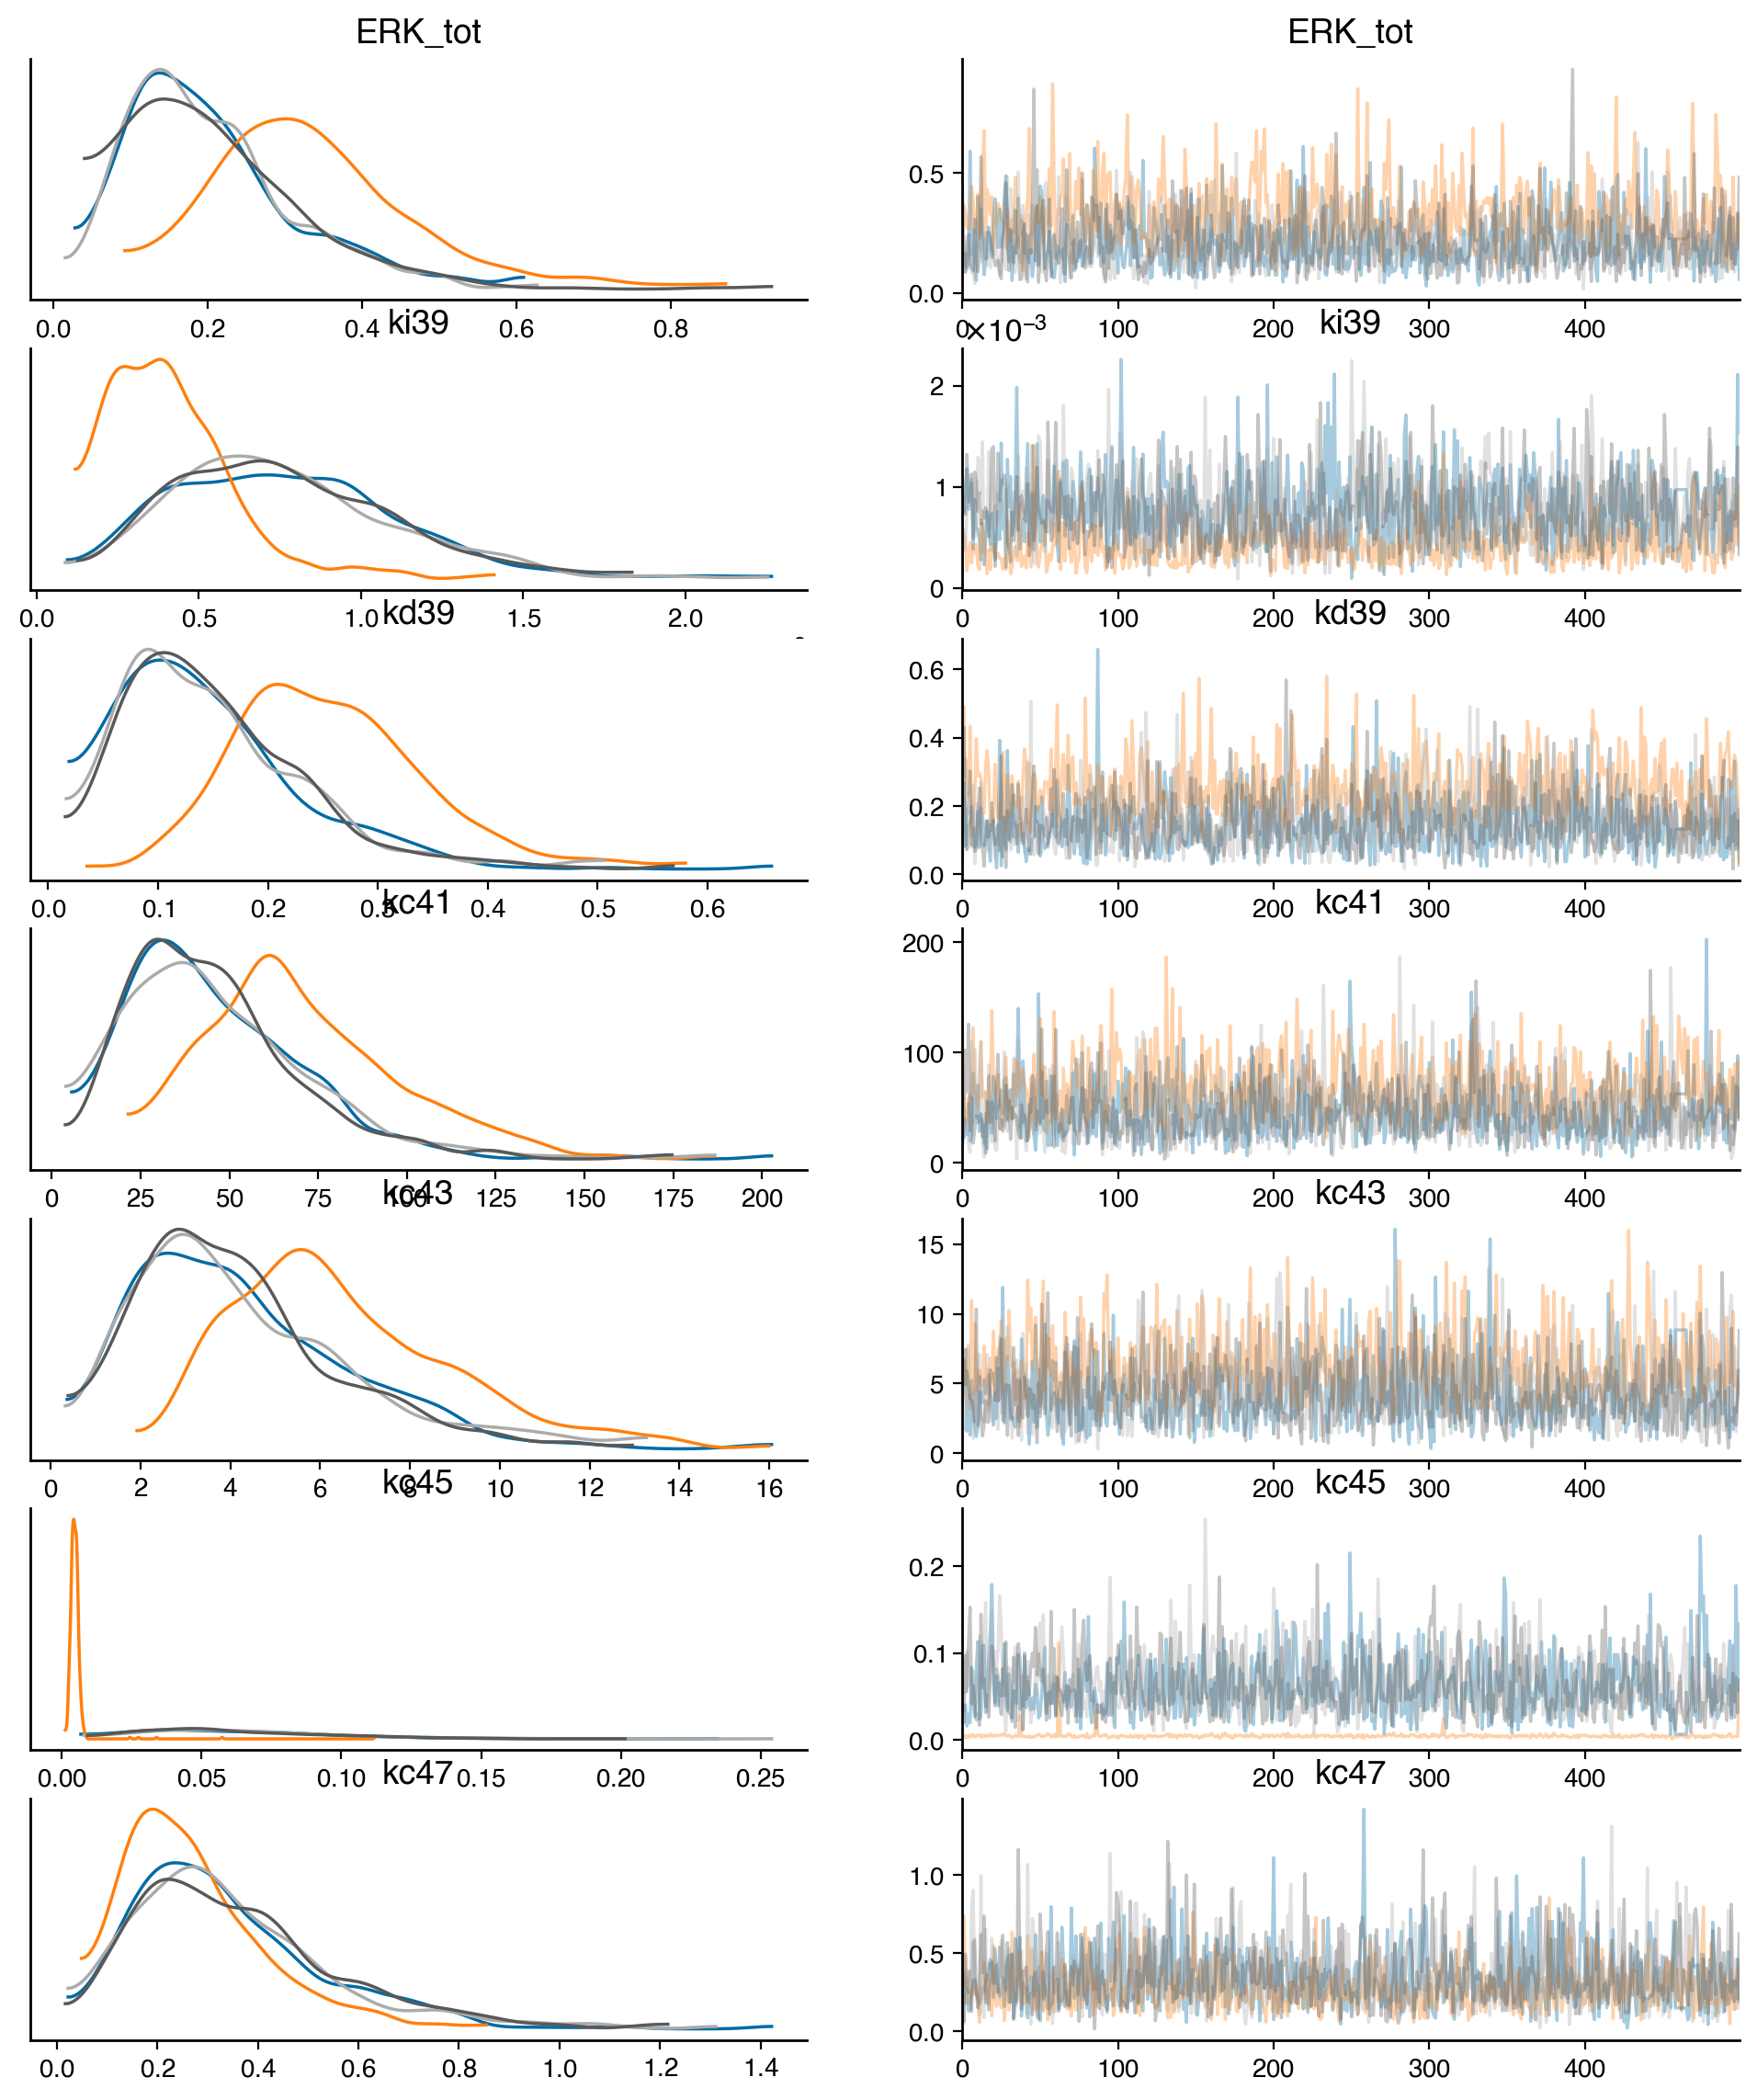

In [51]:
# plot the traces with arviz
az.plot_trace(idata, compact=False)
plt.savefig('./' + 'shin_2014' + '_'+ 'smc' + '_traceplot.pdf',)

# compute the effective sample size and rhat statistics
ess = az.ess(idata)
rhat = az.rhat(idata)

print(ess)
print(rhat)

Sampling: [llike]


(<Figure size 1280x960 with 1 Axes>,
 <Axes: xlabel='EGF stimulus', ylabel='% maximal ERK activity'>)

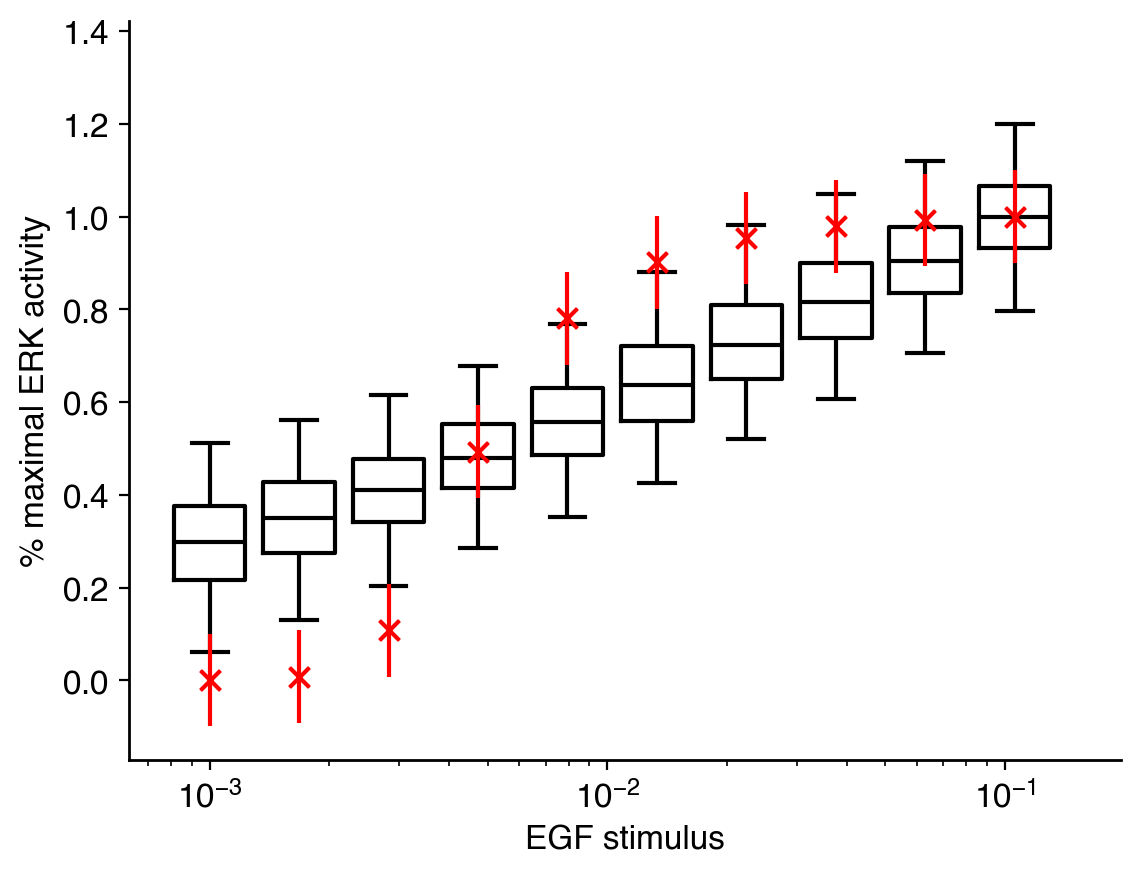

In [53]:
create_posterior_predictive(model1, idata, 'shin_2014', erk_act_data, inputs, './', 
            seed=np.random.default_rng(seed=123))

### Rerun with transient input

In [58]:
S_2014 = shin_2014(transient=True)
y0_dict, y0 = S_2014.get_initial_conditions()
p_dict, plist = S_2014.get_nominal_params()

data = pd.read_csv("../../../results/MAPK/HF_96_synthetic_data.csv")
inputs = np.array(data['stimulus'].to_numpy())
erk_act_data = data['response'].to_numpy()

erk_act_data = np.vstack((data['response'].to_numpy()))

y0_EGF_ins = construct_y0_EGF_inputs(0.001*inputs, np.array([y0]), 0)

# free params
free_param_names = ['kc47', 'kc43', 'kd39', 'kc45', 'ERK_tot', 'ki39', 'kc41']
free_param_idxs = [list(p_dict.keys()).index(name) for name in free_param_names]

# set priors
prior_param_dict = set_prior_params(list(p_dict.keys()), plist, free_param_idxs, prior_family={'Gamma':['alpha', 'beta']}, upper_mult=1.9, lower_mult=0.1, prob_mass_bounds=0.95)

In [59]:
model1 = build_pymc_model(prior_param_dict, erk_act_data, y0_EGF_ins, 
                    [-1], 540, diffrax.ODETerm(S_2014))

Sampling: [ERK_tot, kc41, kc43, kc45, kc47, kd39, ki39, llike]


(<Figure size 1280x960 with 1 Axes>,
 <Axes: xlabel='EGF stimulus', ylabel='% maximal ERK activity'>)

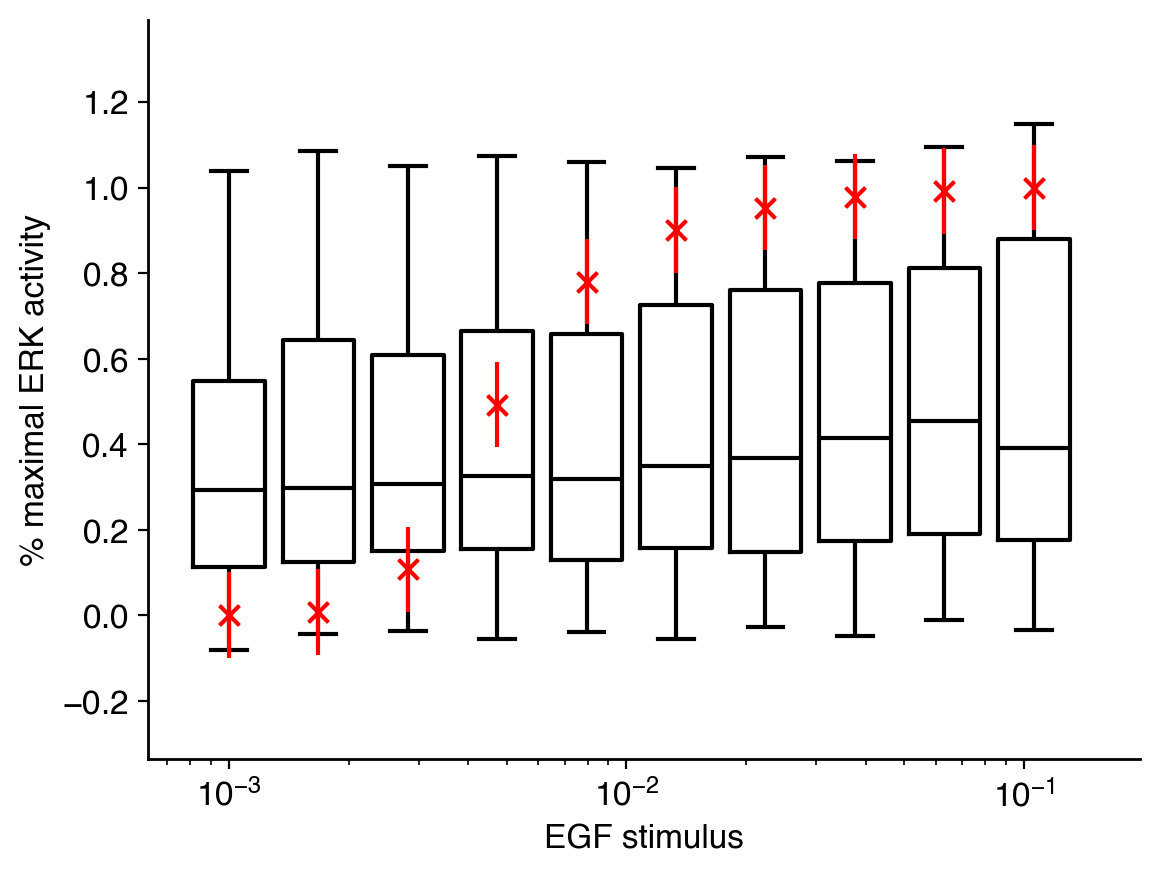

In [60]:
create_prior_predictive(model1, 'shin_2014', erk_act_data, inputs, './', 
                            nsamples=500, seed=np.random.default_rng(seed=123))

In [61]:
# sample
idata = smc_pymc(model1, 'shin_2014', './', nsamples=500, 
             seed=np.random.default_rng(seed=123))

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


<xarray.Dataset>
Dimensions:  ()
Data variables:
    ERK_tot  float64 1.763e+03
    ki39     float64 1.823e+03
    kd39     float64 1.997e+03
    kc41     float64 1.794e+03
    kc43     float64 2.047e+03
    kc45     float64 1.548e+03
    kc47     float64 2.076e+03
<xarray.Dataset>
Dimensions:  ()
Data variables:
    ERK_tot  float64 1.002
    ki39     float64 1.0
    kd39     float64 0.9998
    kc41     float64 1.002
    kc43     float64 1.001
    kc45     float64 0.9997
    kc47     float64 1.004


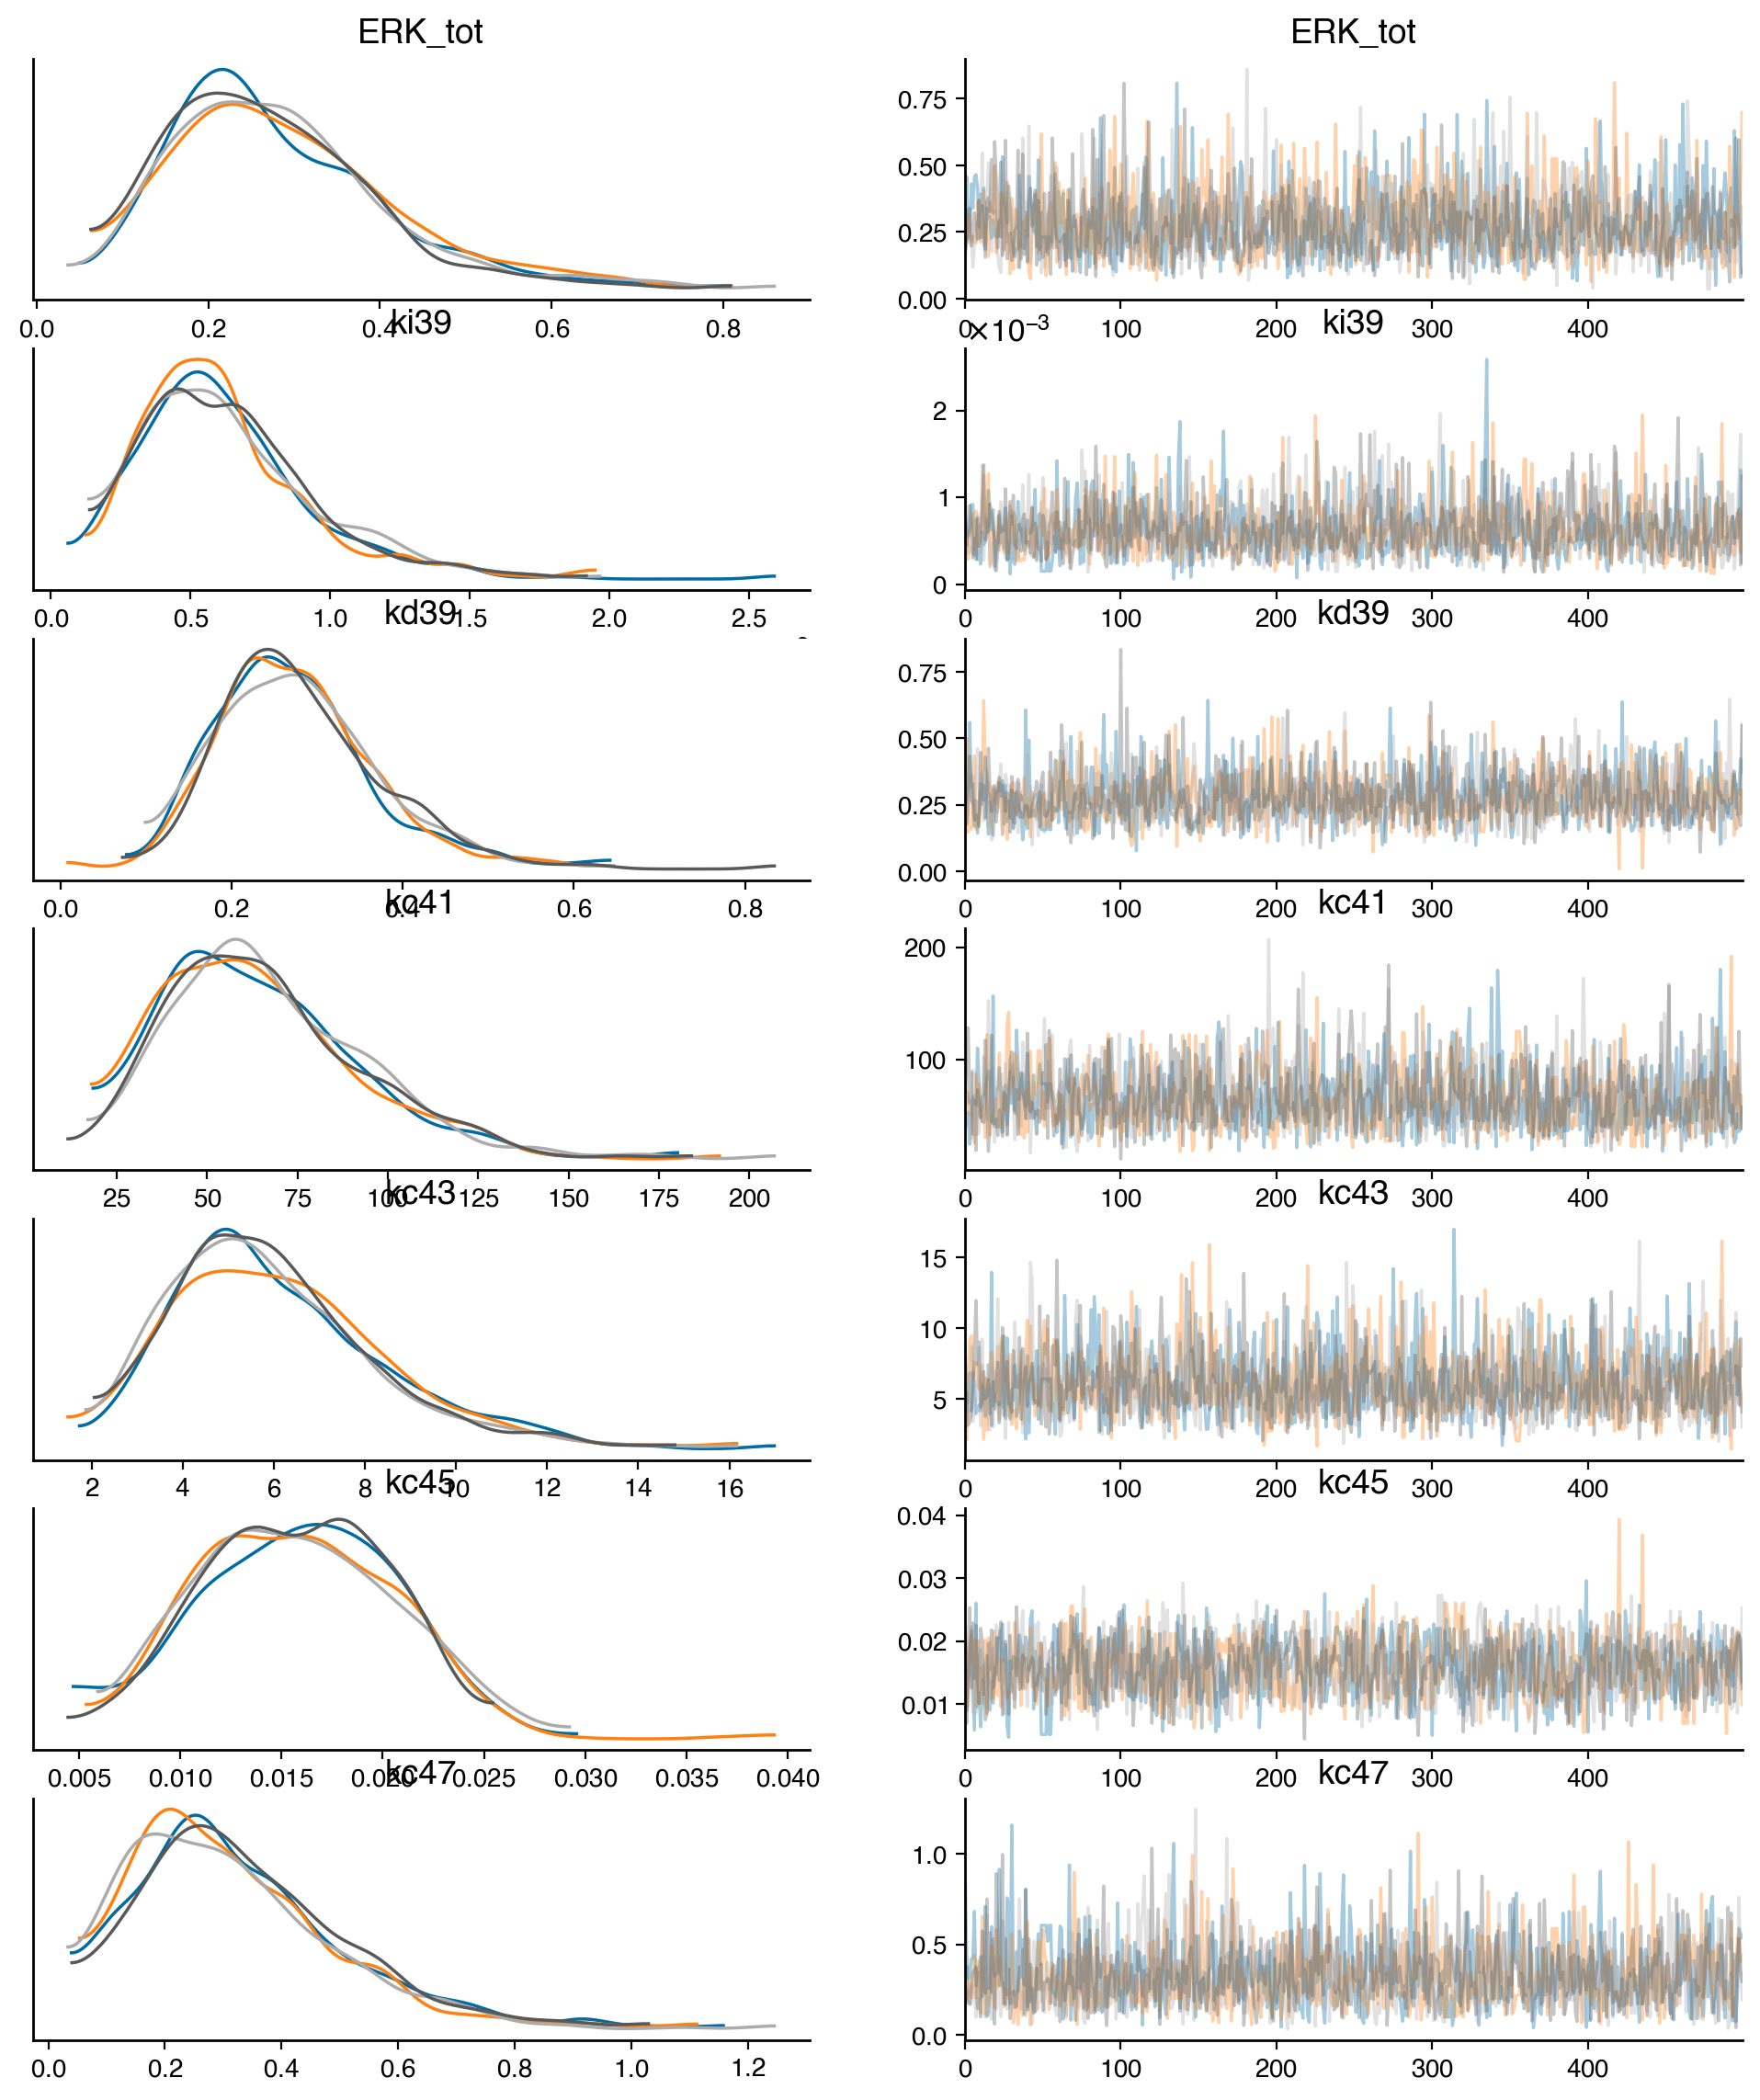

In [62]:
# plot the traces with arviz
az.plot_trace(idata, compact=False)
plt.savefig('./' + 'shin_2014' + '_'+ 'smc' + '_traceplot.pdf',)

# compute the effective sample size and rhat statistics
ess = az.ess(idata)
rhat = az.rhat(idata)

print(ess)
print(rhat)

Sampling: [llike]


(<Figure size 1280x960 with 1 Axes>,
 <Axes: xlabel='EGF stimulus', ylabel='% maximal ERK activity'>)

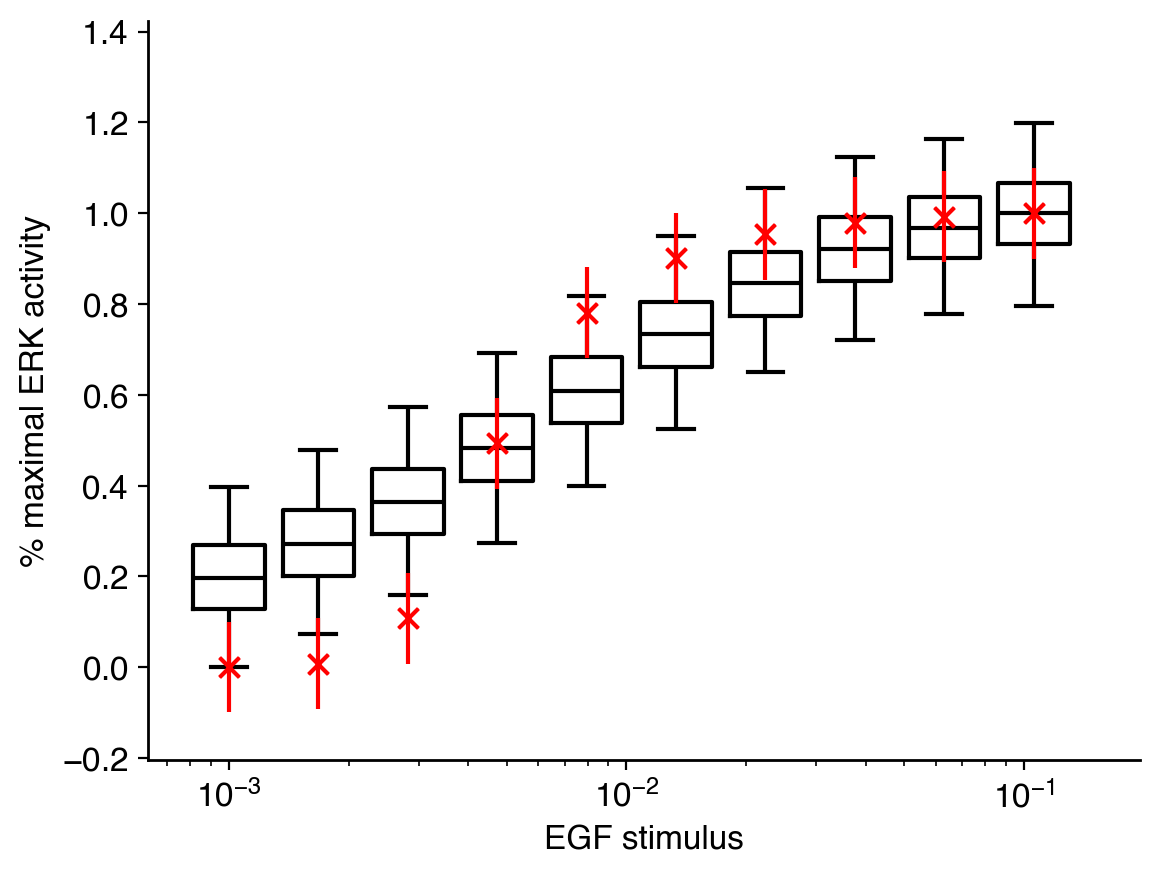

In [63]:
create_posterior_predictive(model1, idata, 'shin_2014', erk_act_data, inputs, './', 
            seed=np.random.default_rng(seed=123))

Test some things with BF

In [4]:
#python inference_process_prior_transient.py -model brightman_fell_2000 -free_params k1,kn1,DT,E,k2,f,kn3,k3,k2_4,k4,k5,k6,k7,kn7,k8,k9,K_9,V_10,K_10,k11,kn11,k12,kn12,k_13,k14,kn14,k15,k16,kn16,k17,V_18,K_18,k19,K_19,V_20,K_20,k21,K_21,V_22,K_22,k23,K_23,V_24,K_24,k25,K_25,V_26,K_26,k27,K_27,V_28,K_28 -data_file ../../../results/MAPK/HF_96_synthetic_data.csv -nsamples 1000 -ncores 1 -savedir ./test_BF_transient -t1 3000 -input_state L -EGF_conversion_factor 1e-7 -ERK_states ERKPP


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15), CpuDevice(id=16), CpuDevice(id=17), CpuDevice(id=18), CpuDevice(id=19), CpuDevice(id=20), CpuDevice(id=21), CpuDevice(id=22), CpuDevice(id=23), CpuDevice(id=24), CpuDevice(id=25), CpuDevice(id=26), CpuDevice(id=27), CpuDevice(id=28), CpuDevice(id=29), CpuDevice(id=30), CpuDevice(id=31), CpuDevice(id=32), CpuDevice(id=33), CpuDevice(id=34), CpuDevice(id=35), CpuDevice(id=36), CpuDevice(id=37), CpuDevice(id=38), CpuDevice(id=39), CpuDevice(id=40), CpuDevice(id=41), CpuDevice(id=42), CpuDevice(id=43), CpuDevice(id=44), CpuDevice(id=45), CpuDevice(id=46), CpuDevice(id=47), CpuDevice(id=48), CpuDevice(id=49), CpuDevice(id=50), CpuDevice(id=51), CpuDevice(id=52), CpuDevice(id=53), CpuDevice(id=54), CpuDevice(id=55), C

 The requested mass is 0.95, but the computed one is 1
 The requested mass is 0.95, but the computed one is 0.941
 The requested mass is 0.95, but the computed one is 0.95
 The requested mass is 0.95, but the computed one is 0.95
 The requested mass is 0.95, but the computed one is 0.95
 The requested mass is 0.95, but the computed one is 0.937
 The requested mass is 0.95, but the computed one is 0.95
 The requested mass is 0.95, but the computed one is 0.95
Sampling: [DT, E, K_10, K_18, K_19, K_20, K_21, K_22, K_23, K_24, K_25, K_26, K_27, K_28, K_9, V_10, V_18, V_20, V_22, V_24, V_26, V_28, f, k1, k11, k12, k14, k15, k16, k17, k19, k2, k21, k23, k25, k27, k2_4, k3, k4, k5, k6, k7, k8, k9, k_13, kn1, kn11, kn12, kn14, kn16, kn3, kn7, llike]
Traceback (most recent call last):
  File "/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/multimodel-inference/src/MAPK/param_est/inference_process_prior_transient.py", line 128, in <module>
    main()
  File "/Users/na

256